In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def calculate_received_power(tx_power, distance, path_loss_exp, shadowing):
    path_loss = 10 * path_loss_exp * np.log10(distance)
    received_power = tx_power - path_loss + shadowing
    return received_power

############ Add this new function after your existing functions in cell 1:

def extract_enhanced_features(received_powers):
    """
    Extract comprehensive statistical features from received power measurements
    to better distinguish between PU and PUEA signals.
    
    Parameters:
        received_powers: Array of received power measurements
        
    Returns:
        List of statistical features
    """
    # Basic statistics (already used in the original code)
    mean = np.mean(received_powers)
    variance = np.var(received_powers)
    median = np.median(received_powers)
    lower_quartile = np.percentile(received_powers, 25)
    upper_quartile = np.percentile(received_powers, 75)
    
    # Additional statistics for better discrimination
    iqr = upper_quartile - lower_quartile  # Interquartile range
    skewness = scipy.stats.skew(received_powers)  # Distribution asymmetry
    kurtosis = scipy.stats.kurtosis(received_powers)  # Peak sharpness
    
    # Energy-related features
    peak_to_avg = np.max(received_powers) / (mean + 1e-10)  # Peak-to-average ratio
    min_max_ratio = np.min(received_powers) / (np.max(received_powers) + 1e-10)  # Dynamic range
    
    # Range statistics
    power_range = np.max(received_powers) - np.min(received_powers)
    coefficient_var = np.std(received_powers) / (mean + 1e-10)  # Coefficient of variation
    
    return [mean, variance, median, lower_quartile, upper_quartile, 
            iqr, skewness, kurtosis, peak_to_avg, min_max_ratio, 
            power_range, coefficient_var]


def run_simulation(primary_power, puea_power, num_iterations, primary_position, puea_position, scenario_name):
    # Network parameters
    num_secondary_users = 20
    area_size = 100

    # Initialize separate result matrices for PU and PUEA for each time slot
    pu_result_matrix = []
    puea_result_matrix = []

    # Initialize arrays to store statistical features for each iteration
    pu_features = []
    puea_features = []

    # Calculate distance between PU and PUEA for reference
    pu_puea_distance = calculate_distance(primary_position, puea_position)

    # Plot network topology for this scenario
    plt.figure(figsize=(10, 10))
    plt.title(f'Scenario {scenario_name}: Network Topology\nPU-PUEA Distance: {pu_puea_distance:.2f} units')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')

    # Generate positions of secondary users (constant for all iterations in this scenario)
    # Use ASCII value of first character as a seed offset
    seed_value = 42 + (ord(scenario_name[0]) - ord('A'))
    np.random.seed(seed_value)
    secondary_positions = np.random.uniform(0, area_size, size=(num_secondary_users, 2))

    # Plot secondary users
    plt.scatter(secondary_positions[:, 0], secondary_positions[:, 1],
               label='Secondary Users', c='blue', marker='o')

    # Plot primary user and PUEA
    plt.scatter(primary_position[0], primary_position[1],
               label='Primary User', c='red', marker='^', s=200)
    plt.scatter(puea_position[0], puea_position[1],
               label='PUEA', c='green', marker='s', s=200)

    # Annotate secondary users
    for i in range(num_secondary_users):
        plt.annotate(f'SU{i+1}', (secondary_positions[i, 0], secondary_positions[i, 1]))

    plt.grid(True)
    plt.legend()
    plt.axis([0, area_size, 0, area_size])
    #plt.savefig(f'scenario_{scenario_name}_topology.png')
    plt.show()

    # Time slot simulation
    print(f"\n===== Scenario {scenario_name} - Simulation over {num_iterations} Time Slots =====")
    print(f"PU Position: ({primary_position[0]}, {primary_position[1]})")
    print(f"PUEA Position: ({puea_position[0]}, {puea_position[1]})")
    print(f"PU-PUEA Distance: {pu_puea_distance:.2f} units")

    # Create arrays to store received powers for each time slot for visualization
    time_slots = np.arange(1, num_iterations + 1)
    avg_pu_power_per_slot = np.zeros(num_iterations)
    avg_puea_power_per_slot = np.zeros(num_iterations)

    for time_slot in range(num_iterations):
        # Add some randomness per time slot (represents changing channel conditions)
        np.random.seed(100 + time_slot)

        # Initialize arrays
        distances_to_primary = np.zeros(num_secondary_users)
        distances_to_puea = np.zeros(num_secondary_users)
        path_loss_exponents = np.random.uniform(2, 6, num_secondary_users)  # Range 2-6
        shadowing_values = np.random.uniform(4, 12, num_secondary_users)  # Range 4-12
        received_powers_primary = np.zeros(num_secondary_users)
        received_powers_puea = np.zeros(num_secondary_users)

        # Calculate features
        for i in range(num_secondary_users):
            distances_to_primary[i] = calculate_distance(secondary_positions[i], primary_position)
            distances_to_puea[i] = calculate_distance(secondary_positions[i], puea_position)

            received_powers_primary[i] = calculate_received_power(
                primary_power,
                distances_to_primary[i],
                path_loss_exponents[i],
                shadowing_values[i]
            )

            received_powers_puea[i] = calculate_received_power(
                puea_power,
                distances_to_puea[i],
                path_loss_exponents[i],
                shadowing_values[i]
            )

        # Store average powers for this time slot
        avg_pu_power_per_slot[time_slot] = np.mean(received_powers_primary)
        avg_puea_power_per_slot[time_slot] = np.mean(received_powers_puea)

        # Print results for each time slot
        print(f"\nTime Slot {time_slot + 1}:")
        print(f"Average PU Received Power: {avg_pu_power_per_slot[time_slot]:.2f} dB")
        print(f"Average PUEA Received Power: {avg_puea_power_per_slot[time_slot]:.2f} dB")

        # Print detailed array of received powers from each source
        print("Array of received powers from Primary User:")
        print(received_powers_primary)
        print("Array of received powers from PUEA:")
        print(received_powers_puea)

        # Append to respective result matrices
        pu_result_matrix.append(received_powers_primary)
        puea_result_matrix.append(received_powers_puea)

        # # Calculate statistical features for primary user
        # pu_mean = np.mean(received_powers_primary)
        # pu_variance = np.var(received_powers_primary)
        # pu_median = np.median(received_powers_primary)
        # pu_lower_quartile = np.percentile(received_powers_primary, 25)
        # pu_upper_quartile = np.percentile(received_powers_primary, 75)

        # # Calculate statistical features for PUEA
        # puea_mean = np.mean(received_powers_puea)
        # puea_variance = np.var(received_powers_puea)
        # puea_median = np.median(received_powers_puea)
        # puea_lower_quartile = np.percentile(received_powers_puea, 25)
        # puea_upper_quartile = np.percentile(received_powers_puea, 75)

        # # Store statistical features as a training example with energy labels
        # pu_features.append([pu_mean, pu_variance, pu_median, pu_lower_quartile, pu_upper_quartile, 0])  # Label 0 for PU
        # puea_features.append([puea_mean, puea_variance, puea_median, puea_lower_quartile, puea_upper_quartile, 1])  # Label 1 for PUEA

        ########################################################################################
        # In the run_simulation function, modify the feature extraction section around line 146-179:

        # Use the enhanced feature extraction function
        # Calculate ONE feature vector per time slot by aggregating across all secondary users
        pu_enhanced_features = extract_enhanced_features(received_powers_primary)
        puea_enhanced_features = extract_enhanced_features(received_powers_puea)

        # Add the class labels (0 for PU, 1 for PUEA)
        pu_features.append(pu_enhanced_features + [0])  # Label 0 for PU
        puea_features.append(puea_enhanced_features + [1])  # Label 1 for PUEA

        # For printing the basic statistics (to maintain output format)
        pu_mean = pu_enhanced_features[0]
        pu_variance = pu_enhanced_features[1]
        pu_median = pu_enhanced_features[2]
        pu_lower_quartile = pu_enhanced_features[3]
        pu_upper_quartile = pu_enhanced_features[4]

        puea_mean = puea_enhanced_features[0]
        puea_variance = puea_enhanced_features[1]
        puea_median = puea_enhanced_features[2]
        puea_lower_quartile = puea_enhanced_features[3]
        puea_upper_quartile = puea_enhanced_features[4]

        ######################################################################################

        # Print statistical features
        print("\nStatistical Features for PU:")
        print(f"  Mean: {pu_mean:.2f}, Variance: {pu_variance:.2f}, Median: {pu_median:.2f}")
        print(f"  Lower Quartile: {pu_lower_quartile:.2f}, Upper Quartile: {pu_upper_quartile:.2f}")

        print("\nStatistical Features for PUEA:")
        print(f"  Mean: {puea_mean:.2f}, Variance: {puea_variance:.2f}, Median: {puea_median:.2f}")
        print(f"  Lower Quartile: {puea_lower_quartile:.2f}, Upper Quartile: {puea_upper_quartile:.2f}")

    # Convert feature lists to numpy arrays for easier handling
    pu_features = np.array(pu_features)
    puea_features = np.array(puea_features)

    return pu_result_matrix, puea_result_matrix, avg_pu_power_per_slot, avg_puea_power_per_slot, pu_features, puea_features

# Main simulation parameters
primary_power = 20  # Constant value for primary user
puea_power = 30     # Fixed PUEA power for all scenarios

#########################################################################
num_time_slots = 500 # Number of time slots (iterations) per scenario
##########################################################################

# Define the three scenarios with different PU and PUEA positions
scenarios = {
    'A': {
        'primary_position': np.array([30, 30]),
        'puea_position': np.array([70, 70]),
        'description': 'Far distance'
    },
    'B': {
        'primary_position': np.array([40, 40]),
        'puea_position': np.array([60, 60]),
        'description': 'Medium distance'
    },
    'C': {
        'primary_position': np.array([45, 45]),
        'puea_position': np.array([55, 55]),
        'description': 'Close distance'
    }
}


# Store results for different scenarios
scenario_results = {}
matrix_for_combining_scenarios = []

# Define percentages of PUEA energy labels to mix with PU labels
puea_percentages = [10, 20, 30, 40, 50]

# Store combined matrices for each case
scenario_case_matrices = {}

# Iterate through each scenario
# ...existing code...
for scenario_name, scenario_config in scenarios.items():
    print(f"\n\n========== SCENARIO {scenario_name}: {scenario_config['description']} ==========")

    primary_position = scenario_config['primary_position']
    puea_position = scenario_config['puea_position']

    pu_result, puea_result, avg_pu_per_slot, avg_puea_per_slot, pu_features, puea_features = run_simulation(
        primary_power,
        puea_power,
        num_time_slots,
        primary_position,
        puea_position,
        scenario_name
    )

    # Store results for original scenario
    scenario_results[scenario_name] = {
        'pu_result': pu_result,
        'puea_result': puea_result,
        'avg_pu_per_slot': avg_pu_per_slot,
        'avg_puea_per_slot': avg_puea_per_slot,
        'primary_position': primary_position,
        'puea_position': puea_position,
        'description': scenario_config['description'],
        'pu_features': pu_features,
        'puea_features': puea_features
    }

    print(f"\nCompleted simulation for Scenario {scenario_name}: {scenario_config['description']}")
    print(f"PU Features Matrix Shape: {pu_features.shape}")
    print(f"PUEA Features Matrix Shape: {puea_features.shape}")

    # Display the feature matrices
    print("\nPU Features Matrix (Rows: Time Slots, Columns: [Mean, Variance, Median, Lower Quartile, Upper Quartile]):")
    print(pu_features)

    print("\nPUEA Features Matrix (Rows: Time Slots, Columns: [Mean, Variance, Median, Lower Quartile, Upper Quartile]):")
    print(puea_features)

    # Combine the processed matrices into a single matrix for the base scenario
    combined_matrix = np.vstack((pu_features, puea_features))
    print("Combined Matrix for Base Scenario:")
    print(combined_matrix)
    matrix_for_combining_scenarios.append(combined_matrix)

    # Save the original combined matrix to a CSV file
    original_combined_file = f"{scenario_name}_original_combined_matrix.csv"
    columns = ['Mean', 'Variance', 'Median', 'Lower Quartile', 'Upper Quartile',
            'IQR', 'Skewness', 'Kurtosis', 'Peak_to_Avg', 'Min_Max_Ratio',
            'Power_Range', 'Coefficient_Var', 'Label']

    pd.DataFrame(combined_matrix, columns=columns).to_csv(original_combined_file, index=False)
    print(f"Saved original combined matrix for Scenario {scenario_name} to {original_combined_file}")

    # Now create 5 different cases for each scenario based on different percentages
    print(f"\nCreating different percentage cases for scenario {scenario_name}:")

    # Always use only the first num_time_slots PU and PUEA features
    pu_features_trimmed = pu_features[:num_time_slots]
    puea_features_trimmed = puea_features[:num_time_slots]

    for percentage in puea_percentages:
        num_puea_samples = max(1, int(round(num_time_slots * (percentage / 100))))
        num_pu_samples = num_time_slots - num_puea_samples

        # Shuffle before selecting to avoid always picking the same samples
        np.random.seed(int(percentage * 100 + ord(scenario_name[0])))
        pu_shuffled = pu_features_trimmed.copy()
        puea_shuffled = puea_features_trimmed.copy()
        np.random.shuffle(pu_shuffled)
        np.random.shuffle(puea_shuffled)

        selected_pu_features = pu_shuffled[:num_pu_samples]
        selected_puea_features = puea_shuffled[:num_puea_samples]

        # Combine and shuffle again
        case_combined_matrix = np.vstack((selected_pu_features, selected_puea_features))
        np.random.shuffle(case_combined_matrix)

        case_name = f"{scenario_name}_case_{percentage}percent"
        scenario_case_matrices[case_name] = case_combined_matrix

        output_file = f"{case_name}_matrix.csv"
        pd.DataFrame(case_combined_matrix, columns=columns).to_csv(output_file, index=False)

        print(f"  Created case {case_name} with {num_puea_samples} PUEA samples and {num_pu_samples} PU samples (total {num_time_slots})")
        print(f"  Saved combined matrix to {output_file}")

# Combine all original scenario matrices into one final matrix with gaps
final_matrix = []
for i, matrix in enumerate(matrix_for_combining_scenarios):
    # Add an identifier column to distinguish between matrices
    identifier_column = np.full((matrix.shape[0], 1), i)  # Identifier for each matrix
    matrix_with_id = np.hstack((matrix, identifier_column))
    final_matrix.append(matrix_with_id)

# Stack all matrices vertically
final_matrix = np.vstack(final_matrix)

# Save the final matrix to a CSV file
output_file = "final_matrix.csv"
columns = ['Mean', 'Variance', 'Median', 'Lower Quartile', 'Upper Quartile', 
           'IQR', 'Skewness', 'Kurtosis', 'Peak_to_Avg', 'Min_Max_Ratio', 
           'Power_Range', 'Coefficient_Var', 'Label', 'Matrix_ID']
pd.DataFrame(final_matrix, columns=columns).to_csv(output_file, index=False)

print(f"\nAll original scenario matrices combined and saved to {output_file}")

# Compare scenarios with scatter plot
plt.figure(figsize=(7, 5))

# Plot average PU and PUEA received powers for each scenario
for scenario_name, results in scenario_results.items():
    # Calculate distance between PU and PUEA
    distance = calculate_distance(results['primary_position'], results['puea_position'])

    # Calculate overall average powers across all time slots
    avg_pu = np.mean(results['avg_pu_per_slot'])
    avg_puea = np.mean(results['avg_puea_per_slot'])

    # Add points to the scatter plot
    plt.scatter(distance, avg_pu, label=f'PU - Scenario {scenario_name}',
                marker='o', s=100, edgecolors='black')
    plt.scatter(distance, avg_puea, label=f'PUEA - Scenario {scenario_name}',
                marker='s', s=100, edgecolors='black')

plt.title('Comparison of Scenarios: Effect of PU-PUEA Distance on Received Power')
plt.xlabel('Distance between PU and PUEA')
plt.ylabel('Average Received Power (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('scenario_comparison.png')
plt.show()

# Output summary of statistical features
print("\n===== STATISTICAL FEATURES SUMMARY =====")
for scenario_name, results in scenario_results.items():
    distance = calculate_distance(results['primary_position'], results['puea_position'])
    print(f"\nScenario {scenario_name}: {results['description']} (PU-PUEA Distance: {distance:.2f} units)")

# Output summary of cases created
print("\n===== PERCENTAGE CASES SUMMARY =====")
for case_name in sorted(scenario_case_matrices.keys()):
    matrix = scenario_case_matrices[case_name]
    num_pu = np.sum(matrix[:, 5] == 0)
    num_puea = np.sum(matrix[:, 5] == 1)
    total = len(matrix)
    print(f"Case {case_name}: {num_pu} PU samples ({num_pu/total*100:.1f}%), {num_puea} PUEA samples ({num_puea/total*100:.1f}%), Total: {total}")

# Output overall summary
print("\n===== SIMULATION OVERALL SUMMARY =====")
print(f"Primary User Power: {primary_power} dB (constant)")
print(f"PUEA Power: {puea_power} dB (constant)")
print(f"Number of Time Slots per Scenario: {num_time_slots}")
print("\nScenario Descriptions:")

for scenario_name, results in scenario_results.items():
    distance = calculate_distance(results['primary_position'], results['puea_position'])
    print(f"\nScenario {scenario_name}: {results['description']}")
    print(f"  PU Position: ({results['primary_position'][0]}, {results['primary_position'][1]})")
    print(f"  PUEA Position: ({results['puea_position'][0]}, {results['puea_position'][1]})")
    print(f"  PU-PUEA Distance: {distance:.2f} units")

    # Calculate overall average powers across all time slots
    avg_pu = np.mean(results['avg_pu_per_slot'])
    avg_puea = np.mean(results['avg_puea_per_slot'])
    print(f"  Average PU Received Power: {avg_pu:.2f} dB")
    print(f"  Average PUEA Received Power: {avg_puea:.2f} dB")

print(f"\nTotal Cases Created: {len(scenario_case_matrices)}")
print(f"Percentages Used: {puea_percentages}")


===== Processing Scenario A =====
Processing base scenario A with 200 samples
Saved base Manhattan distance matrix for scenario A to manhattan_distance_matrix_scenario_A_base.csv
Processing case A_case_10percent with 100 samples
Saved Manhattan distance matrix for A_case_10percent to manhattan_distance_matrix_A_case_10percent.csv
  Statistics for A_case_10percent:
    Average distance: 284.29
    Min distance: 17.62
    Max distance: 1896.73
    PU-PUEA average distance: 262.95
    PU-PU average distance: 293.63
    PUEA-PUEA average distance: 195.85
Processing case A_case_20percent with 100 samples
Saved Manhattan distance matrix for A_case_20percent to manhattan_distance_matrix_A_case_20percent.csv
  Statistics for A_case_20percent:
    Average distance: 266.38
    Min distance: 18.79
    Max distance: 1885.26
    PU-PUEA average distance: 245.42
    PU-PU average distance: 285.47
    PUEA-PUEA average distance: 195.61
Processing case A_case_30percent with 100 samples
Saved Manhatta

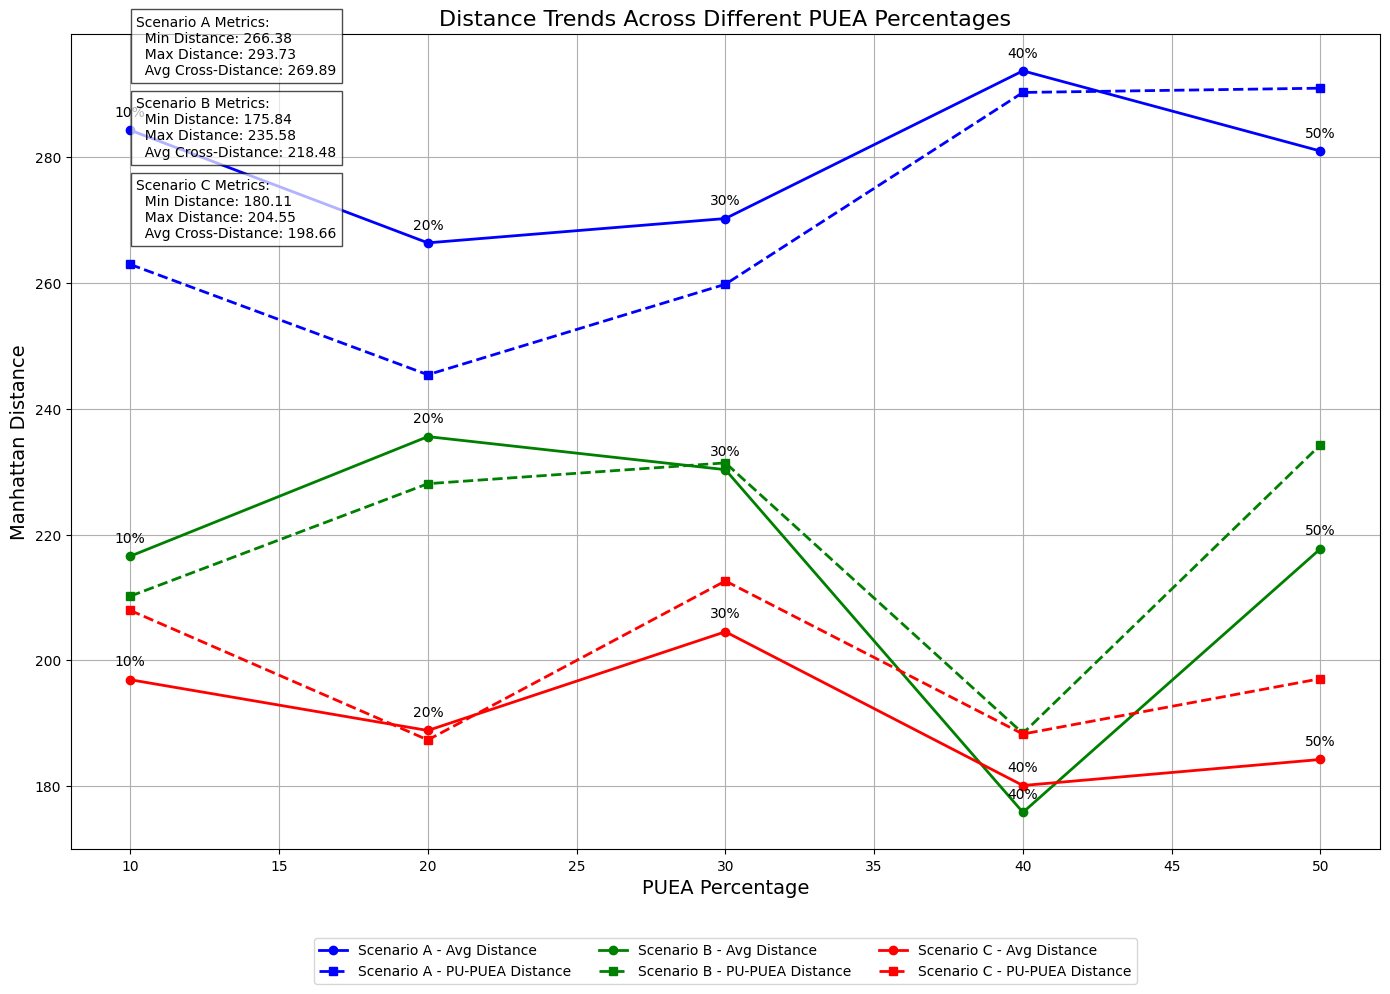

Moved manhattan_distance_matrix_A_case_10percent.csv to manhattan_distances
Moved manhattan_distance_matrix_A_case_20percent.csv to manhattan_distances
Moved manhattan_distance_matrix_A_case_30percent.csv to manhattan_distances
Moved manhattan_distance_matrix_A_case_40percent.csv to manhattan_distances
Moved manhattan_distance_matrix_A_case_50percent.csv to manhattan_distances
Moved manhattan_distance_matrix_B_case_10percent.csv to manhattan_distances
Moved manhattan_distance_matrix_B_case_20percent.csv to manhattan_distances
Moved manhattan_distance_matrix_B_case_30percent.csv to manhattan_distances
Moved manhattan_distance_matrix_B_case_40percent.csv to manhattan_distances
Moved manhattan_distance_matrix_B_case_50percent.csv to manhattan_distances
Moved manhattan_distance_matrix_C_case_10percent.csv to manhattan_distances
Moved manhattan_distance_matrix_C_case_20percent.csv to manhattan_distances
Moved manhattan_distance_matrix_C_case_30percent.csv to manhattan_distances
Moved manhat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import shutil

def save_distance_matrices_to_folder(folder_name="manhattan_distances"):
    """
    Save all CSV distance matrix files into a specified folder.

    Parameters:
        folder_name (str): Name of the folder to save the files.
    """
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # List all files in the current directory
    files = [f for f in os.listdir('.') if f.endswith('.csv') and 'manhattan_distance_matrix' in f]

    # Move each distance matrix file to the folder
    for file in files:
        shutil.move(file, os.path.join(folder_name, file))
        print(f"Moved {file} to {folder_name}")

    print(f"All distance matrix files have been saved to the folder '{folder_name}'.")


def calculate_manhattan_distance_matrix(matrix):
    # Use only feature columns (exclude label and Matrix_ID if present)
    feature_cols = matrix.shape[1] - 1 if matrix.shape[1] <= 6 else matrix.shape[1] - 2
    feature_data = matrix[:, 0:feature_cols]
    # Vectorized Manhattan distance calculation
    diff = np.abs(feature_data[:, np.newaxis, :] - feature_data[np.newaxis, :, :])
    distance_matrix = np.sum(diff, axis=2)
    distance_matrix = np.round(distance_matrix, 2)
    return distance_matrix

# Define the scenarios and percentages (matching the original code)
scenarios = ['A', 'B', 'C']
puea_percentages = [10, 20, 30, 40, 50]

# Function to visualize a distance matrix
def visualize_distance_matrix(distance_matrix, title, filename=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(distance_matrix, cmap='viridis')
    plt.colorbar(label='Manhattan Distance')
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')

    if filename:
        plt.savefig(filename)
    plt.show()

# Process each scenario and percentage case
for scenario in scenarios:
    print(f"\n===== Processing Scenario {scenario} =====")

    # Process base scenario first
    try:
        base_file = f"final_matrix.csv"
        if Path(base_file).exists():
            base_matrix = pd.read_csv(base_file).values
            # Filter for just this scenario's matrix (using Matrix_ID)
            scenario_index = ord(scenario) - ord('A')
            scenario_matrix = base_matrix[base_matrix[:, -1] == scenario_index]

            if len(scenario_matrix) > 0:
                print(f"Processing base scenario {scenario} with {len(scenario_matrix)} samples")
                distance_matrix = calculate_manhattan_distance_matrix(scenario_matrix)
                output_file = f"manhattan_distance_matrix_scenario_{scenario}_base.csv"
                np.savetxt(output_file, distance_matrix, delimiter=",", fmt="%.2f")
                print(f"Saved base Manhattan distance matrix for scenario {scenario} to {output_file}")
        else:
            print(f"Warning: Base file {base_file} not found.")
    except Exception as e:
        print(f"Error processing base scenario {scenario}: {e}")

    # Process each percentage case
    for percentage in puea_percentages:
        case_name = f"{scenario}_case_{percentage}percent"
        case_file = f"{case_name}_matrix.csv"

        try:
            if Path(case_file).exists():
                case_matrix = pd.read_csv(case_file).values
                print(f"Processing case {case_name} with {len(case_matrix)} samples")

                # Calculate Manhattan distance matrix
                distance_matrix = calculate_manhattan_distance_matrix(case_matrix)

                # Save to file
                output_file = f"manhattan_distance_matrix_{case_name}.csv"
                np.savetxt(output_file, distance_matrix, delimiter=",", fmt="%.2f")
                print(f"Saved Manhattan distance matrix for {case_name} to {output_file}")

                # Generate some statistics about the distance matrix
                avg_distance = np.mean(distance_matrix)
                min_distance = np.min(distance_matrix[distance_matrix > 0])  # Exclude self-comparisons
                max_distance = np.max(distance_matrix)

                print(f"  Statistics for {case_name}:")
                print(f"    Average distance: {avg_distance:.2f}")
                print(f"    Min distance: {min_distance:.2f}")
                print(f"    Max distance: {max_distance:.2f}")

                # Compare distances between samples with different labels
                if case_matrix.shape[1] > 5:  # Ensure there's a label column
                    labels = case_matrix[:, 12]  # Index of the Label column (0-indexed)
                    pu_indices = np.where(labels == 0)[0]
                    puea_indices = np.where(labels == 1)[0]

                    if len(pu_indices) > 0 and len(puea_indices) > 0:
                        # Cross-distances between PU and PUEA samples
                        cross_distances = []
                        for i in pu_indices:
                            for j in puea_indices:
                                cross_distances.append(distance_matrix[i, j])

                        cross_distances = np.array(cross_distances)
                        avg_cross_distance = np.mean(cross_distances)

                        # Within-distances for PU samples
                        pu_distances = []
                        for i in range(len(pu_indices)):
                            for j in range(i+1, len(pu_indices)):
                                pu_distances.append(distance_matrix[pu_indices[i], pu_indices[j]])

                        pu_distances = np.array(pu_distances) if pu_distances else np.array([0])
                        avg_pu_distance = np.mean(pu_distances) if len(pu_distances) > 0 else 0

                        # Within-distances for PUEA samples
                        puea_distances = []
                        for i in range(len(puea_indices)):
                            for j in range(i+1, len(puea_indices)):
                                puea_distances.append(distance_matrix[puea_indices[i], puea_indices[j]])

                        puea_distances = np.array(puea_distances) if puea_distances else np.array([0])
                        avg_puea_distance = np.mean(puea_distances) if len(puea_distances) > 0 else 0

                        print(f"    PU-PUEA average distance: {avg_cross_distance:.2f}")
                        print(f"    PU-PU average distance: {avg_pu_distance:.2f}")
                        print(f"    PUEA-PUEA average distance: {avg_puea_distance:.2f}")
            else:
                print(f"Warning: Case file {case_file} not found.")
        except Exception as e:
            print(f"Error processing case {case_name}: {e}")

print("\nAll Manhattan distance matrices have been calculated and saved.")

# Additional analysis: Compare the trends across different percentages for each scenario
try:
    # Store statistics for plotting
    scenario_stats = {scenario: {'percentages': [], 'avg_distances': [], 'cross_distances': []}
                     for scenario in scenarios}

    for scenario in scenarios:
        for percentage in puea_percentages:
            case_name = f"{scenario}_case_{percentage}percent"
            case_file = f"{case_name}_matrix.csv"

            if Path(case_file).exists():
                case_matrix = pd.read_csv(case_file).values
                
                # Adjust index for your specific CSV structure - this is the Label column
                labels = case_matrix[:, 12]  # Update this index to match your data structure

                distance_matrix_file = f"manhattan_distance_matrix_{case_name}.csv"
                if Path(distance_matrix_file).exists():
                    distance_matrix = np.loadtxt(distance_matrix_file, delimiter=",")

                    # Overall average distance
                    avg_distance = np.mean(distance_matrix)

                    # Cross-label average distance
                    pu_indices = np.where(labels == 0)[0]
                    puea_indices = np.where(labels == 1)[0]

                    if len(pu_indices) > 0 and len(puea_indices) > 0:
                        cross_distances = []
                        for i in pu_indices:
                            for j in puea_indices:
                                cross_distances.append(distance_matrix[i, j])

                        avg_cross_distance = np.mean(cross_distances)

                        # Store for plotting
                        scenario_stats[scenario]['percentages'].append(percentage)
                        scenario_stats[scenario]['avg_distances'].append(avg_distance)
                        scenario_stats[scenario]['cross_distances'].append(avg_cross_distance)

    # Plot trends
    # Plot trends with performance metrics in a single figure
    plt.figure(figsize=(14, 10))

    # Define colors and markers for each scenario
    colors = {'A': 'blue', 'B': 'green', 'C': 'red'}

    for scenario in scenarios:
        if scenario_stats[scenario]['percentages']:
            # Sort data points by percentage
            sorted_indices = np.argsort(scenario_stats[scenario]['percentages'])
            sorted_percentages = np.array(scenario_stats[scenario]['percentages'])[sorted_indices]
            sorted_avg_distances = np.array(scenario_stats[scenario]['avg_distances'])[sorted_indices]
            sorted_cross_distances = np.array(scenario_stats[scenario]['cross_distances'])[sorted_indices]
            
            # Plot average distances
            plt.plot(sorted_percentages, sorted_avg_distances,
                    'o-', color=colors[scenario], linewidth=2,
                    label=f'Scenario {scenario} - Avg Distance')
            
            # Plot cross-distances with dashed lines
            plt.plot(sorted_percentages, sorted_cross_distances,
                    's--', color=colors[scenario], linewidth=2,
                    label=f'Scenario {scenario} - PU-PUEA Distance')
            
            # Add percentage labels to each point
            for i, (x, y) in enumerate(zip(sorted_percentages, sorted_avg_distances)):
                plt.annotate(f"{x}%", 
                            (x, y),
                            textcoords="offset points",
                            xytext=(0,10),
                            ha='center')
                
            # Add performance metrics text for each scenario
            plt.text(0.05, 0.95 - 0.1 * (ord(scenario) - ord('A')),
                    f"Scenario {scenario} Metrics:\n"
                    f"  Min Distance: {min(sorted_avg_distances):.2f}\n"
                    f"  Max Distance: {max(sorted_avg_distances):.2f}\n"
                    f"  Avg Cross-Distance: {np.mean(sorted_cross_distances):.2f}",
                    transform=plt.gca().transAxes,
                    bbox=dict(facecolor='white', alpha=0.7),
                    fontsize=10)

    plt.xlabel('PUEA Percentage', fontsize=14)
    plt.ylabel('Manhattan Distance', fontsize=14)
    plt.title('Distance Trends Across Different PUEA Percentages', fontsize=16)
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.tight_layout()
    plt.savefig('distance_trends_with_metrics.png', dpi=300)
    plt.show()

    # Only after plotting is done, move the files
    save_distance_matrices_to_folder()

except Exception as e:
    print(f"Error in trend analysis: {e}")
    # Print more detailed error information for debugging
    import traceback
    traceback.print_exc()

In [ ]:
# Modified Cell 3 with Enhanced Ensemble Clustering

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import glob
from pathlib import Path
from sklearn.preprocessing import StandardScaler

def extract_metadata(filename):
    """
    Extract case and scenario from a filename with pattern 'distance_matrix_X_case_Ypercent'

    Parameters:
        filename (str): The filename to extract metadata from

    Returns:
        tuple: (case, scenario) where case is 'A', 'B', or 'C' and scenario is '10percent', etc.
    """
    match = re.search(r'_([A-C])_case_(\d+percent)', filename)
    if match:
        case = match.group(1)
        scenario = match.group(2)
        return case, scenario
    return None, None

def load_distance_matrix(file_path):
    """
    Load a distance matrix from a CSV file
    Parameters:
        file_path (str): Path to the CSV file
    Returns:
        numpy.ndarray: The distance matrix
    """
    # Extract filename for processing message
    filename = os.path.basename(file_path)
    print(f"Processing {filename}...")

    # First, try loading without treating any rows or columns as headers or indices
    try:
        data = np.loadtxt(file_path, delimiter=',')
        return data
    except Exception as e:
        pass

    # If that fails, try pandas but with header=None and index_col=None to keep all rows/columns
    try:
        df = pd.read_csv(file_path, header=None, index_col=None)
        return df.values
    except Exception as e:
        pass

    # Last resort: try with raw reading to ensure no rows/columns are lost
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        matrix = []
        for line in lines:
            values = [float(x) for x in line.strip().split(',') if x.strip()]
            if values:
                matrix.append(values)

        data = np.array(matrix)
        return data
    except Exception as e:
        raise ValueError(f"Failed to load distance matrix from {filename}: {e}")

def perform_kmeans(feature_vectors, n_clusters=2, n_init=10):
    """
    Perform KMeans clustering and ensure binary labels (0 or 1)
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=n_init)
    labels = kmeans.fit_predict(feature_vectors)
    
    # Ensure binary labels
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        min_label = np.min(unique_labels)
        binary_labels = np.zeros_like(labels)
        binary_labels[labels != min_label] = 1
        return binary_labels
    else:
        # In the rare case of only one cluster
        n_samples = len(labels)
        binary_labels = np.zeros(n_samples)
        binary_labels[n_samples//2:] = 1
        return binary_labels

def perform_agglomerative(feature_vectors, n_clusters=2, linkage_method='ward'):
    """
    Perform Agglomerative clustering and ensure binary labels (0 or 1)
    """
    agg_cluster = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='euclidean',
        linkage=linkage_method
    )
    return agg_cluster.fit_predict(feature_vectors)

def perform_dbscan(feature_vectors, eps, min_samples):
    """
    Perform DBSCAN clustering and ensure exactly 2 clusters (PU and PUEA).
    
    Parameters:
        feature_vectors (numpy.ndarray): The feature vectors for clustering
        eps (float): The maximum distance between samples for neighborhood
        min_samples (int): Minimum number of samples in a neighborhood
        
    Returns:
        numpy.ndarray: Binary cluster labels (0 or 1)
    """
    # Run DBSCAN with provided parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(feature_vectors)
    
    # Get unique labels (excluding noise)
    unique_clusters = np.unique(labels)
    non_noise_clusters = unique_clusters[unique_clusters >= 0]
    
    # Case 1: If we have exactly 2 clusters
    if len(non_noise_clusters) == 2:
        print(f"DBSCAN found exactly 2 clusters. Perfect!")
        # For noise points (-1), assign to nearest cluster
        if -1 in labels:
            noise_indices = np.where(labels == -1)[0]
            for idx in noise_indices:
                # Find distances to all non-noise points
                non_noise_indices = np.where(labels >= 0)[0]
                distances = np.sqrt(np.sum((feature_vectors[idx] - feature_vectors[non_noise_indices])**2, axis=1))
                # Find the closest non-noise point and use its label
                closest_non_noise_idx = non_noise_indices[np.argmin(distances)]
                labels[idx] = labels[closest_non_noise_idx]
    
    # Case 2: DBSCAN found more than 2 clusters
    elif len(non_noise_clusters) > 2:
        print(f"DBSCAN found {len(non_noise_clusters)} clusters. Reducing to 2...")
        
        # Find the two largest clusters
        cluster_sizes = [np.sum(labels == c) for c in non_noise_clusters]
        largest_clusters = non_noise_clusters[np.argsort(cluster_sizes)[-2:]]
        
        # Create a new binary label array
        new_labels = np.full_like(labels, -1)
        
        # Keep the two largest clusters
        new_labels[labels == largest_clusters[0]] = 0
        new_labels[labels == largest_clusters[1]] = 1
        
        # For all other points (noise + smaller clusters)
        other_indices = np.where(new_labels == -1)[0]
        for idx in other_indices:
            # Calculate distance to points in the 2 main clusters
            cluster0_indices = np.where(new_labels == 0)[0]
            cluster1_indices = np.where(new_labels == 1)[0]
            
            if len(cluster0_indices) > 0 and len(cluster1_indices) > 0:
                dist_to_0 = np.min(np.sqrt(np.sum((feature_vectors[idx] - feature_vectors[cluster0_indices])**2, axis=1)))
                dist_to_1 = np.min(np.sqrt(np.sum((feature_vectors[idx] - feature_vectors[cluster1_indices])**2, axis=1)))
                # Assign to closest cluster
                new_labels[idx] = 0 if dist_to_0 < dist_to_1 else 1
            else:
                # If one cluster is empty, assign to the other
                new_labels[idx] = 0 if len(cluster1_indices) == 0 else 1
        
        labels = new_labels
    
    # Case 3: DBSCAN found 0 or 1 clusters
    else:
        print(f"DBSCAN found too few clusters: {len(non_noise_clusters)}. Creating 2 clusters...")
        
        # Use K-means as fallback to ensure 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(feature_vectors)
    
    # Ensure final binary labeling (0 and 1 only)
    unique_final = np.unique(labels)
    if len(unique_final) == 1:
        # If only one cluster remains, split it in half
        n_samples = len(labels)
        labels[:n_samples//2] = 0
        labels[n_samples//2:] = 1
    elif len(unique_final) == 2:
        # Map to 0 and 1
        min_label = np.min(unique_final)
        max_label = np.max(unique_final)
        labels[labels == min_label] = 0
        labels[labels == max_label] = 1
    
    return labels

def enhanced_ensemble_clustering(feature_vectors, n_clusters=2, eps=0.5, min_samples=5):
    """
    Perform ensemble clustering with weighted voting to ensure exactly 2 clusters.
    
    Parameters:
        feature_vectors (numpy.ndarray): Feature vectors for clustering
        n_clusters (int): Number of clusters for KMeans and Agglomerative (always 2)
        eps (float): Epsilon parameter for DBSCAN
        min_samples (int): Minimum samples parameter for DBSCAN
        
    Returns:
        numpy.ndarray: Binary cluster labels (0 or 1)
    """
    # Force n_clusters to be 2
    n_clusters = 2
    
    # Run all algorithms, ensuring binary outputs
    kmeans_labels = perform_kmeans(feature_vectors, n_clusters)
    agg_labels = perform_agglomerative(feature_vectors, n_clusters)
    dbscan_labels = perform_dbscan(feature_vectors, eps, min_samples)
    
    # Create a safety check - any algorithm returning non-binary labels gets fixed
    for labels in [kmeans_labels, agg_labels, dbscan_labels]:
        unique_labels = np.unique(labels)
        if len(unique_labels) != 2 or not np.all(np.isin(unique_labels, [0, 1])):
            # Fix by converting to 0 and 1
            if len(unique_labels) > 0:
                min_val = np.min(unique_labels)
                binary_labels = np.zeros_like(labels)
                binary_labels[labels != min_val] = 1
                labels[:] = binary_labels[:]
    
    # Compute silhouette scores to weight algorithms
    try:
        kmeans_score = max(0.1, silhouette_score(feature_vectors, kmeans_labels))
        agg_score = max(0.1, silhouette_score(feature_vectors, agg_labels))
        dbscan_score = max(0.1, silhouette_score(feature_vectors, dbscan_labels))
        
        # Normalize weights
        total = kmeans_score + agg_score + dbscan_score
        weights = [kmeans_score/total, agg_score/total, dbscan_score/total]
    except:
        # Default weights if silhouette calculation fails
        weights = [0.4, 0.4, 0.2]
    
    # Weighted voting - ensure binary output
    ensemble_labels = np.zeros(len(feature_vectors))
    for i in range(len(feature_vectors)):
        # Convert any label > 0 to 1 to ensure binary voting
        vote = (weights[0] * (kmeans_labels[i] > 0) + 
                weights[1] * (agg_labels[i] > 0) + 
                weights[2] * (dbscan_labels[i] > 0))
        ensemble_labels[i] = 1 if vote >= 0.5 else 0
    
    print(f"Ensemble clustering complete. Found {len(np.unique(ensemble_labels))} clusters.")
    return ensemble_labels.astype(int)
    
def plot_clusters(feature_vectors, cluster_labels, title, output_folder, cluster_names=None, metrics=None):
    """
    Plot clusters on a 2D scatter plot, enforcing exactly 2 clusters.
    
    Parameters:
        feature_vectors (numpy.ndarray): Feature vectors for visualization
        cluster_labels (numpy.ndarray): Cluster labels
        title (str): Plot title
        output_folder (str): Folder to save the plot
        cluster_names (list): Names for clusters (defaults to ["Primary User", "Attacker"])
        metrics (dict): Optional metrics to display on the plot
    """
    # Default cluster names
    if cluster_names is None or len(cluster_names) < 2:
        cluster_names = ["Primary User", "Attacker"]
    
    # Create binary labels (0 for PU, 1 for PUEA)
    binary_labels = np.copy(cluster_labels)
    
    # Handle any noise points (-1) or multi-cluster cases
    if np.any(binary_labels < 0) or np.any(binary_labels > 1):
        # For noise points (-1), assign to cluster 0
        binary_labels[binary_labels < 0] = 0
        
        # For any value > 1, assign to cluster 1
        binary_labels[binary_labels > 1] = 1
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Fixed colors for two clusters
    colors = ['blue', 'red']
    
    # Plot each cluster
    for i in range(2):
        mask = binary_labels == i
        if np.any(mask):
            plt.scatter(
                feature_vectors[mask, 0],
                feature_vectors[mask, 1],
                c=colors[i],
                s=100,
                edgecolor='k',
                alpha=0.8,
                label=cluster_names[i]
            )
    
    # Add metrics to the title if provided
    if metrics:
        metrics_text = "\n".join([f"{key}: {value:.2f}" for key, value in metrics.items() if value is not None])
        plt.title(f"{title}\n{metrics_text}", fontsize=16, fontweight='bold')
    else:
        plt.title(title, fontsize=16, fontweight='bold')
    
    plt.xlabel("MDS Component 1", fontsize=12)
    plt.ylabel("MDS Component 2", fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Save the plot to file
    plot_filename = os.path.join(output_folder, title.replace(" ", "_").replace(":", "").lower() + ".png")
    plt.savefig(plot_filename)
    plt.close()
    
    print(f"Cluster plot saved: {plot_filename}")

def plot_dendrogram(feature_vectors, title, output_folder, linkage_method='ward'):
    """
    Plot a dendrogram for hierarchical clustering

    Parameters:
        feature_vectors (numpy.ndarray): The feature vectors
        title (str): The title for the plot
        output_folder (str): Folder to save the plot in
        linkage_method (str): The linkage criterion to use
    """
    plt.figure(figsize=(10, 8))
    linked = linkage(feature_vectors, method=linkage_method)
    dendrogram(linked, orientation='right')
    plt.title(f'Hierarchical Clustering Dendrogram: {title}', fontsize=14)
    plt.xlabel('Distance', fontsize=12)
    plt.ylabel('Sample Index', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Save the plot to file
    plot_filename = os.path.join(output_folder, f"dendrogram_{title.replace(' ', '_').replace(':', '').lower()}.png")
    plt.savefig(plot_filename)
    plt.close()

def create_result_folders():
    """
    Create folders for storing results of each clustering algorithm

    Returns:
        dict: Dictionary with paths to each clustering algorithm's folder
    """
    # Create main results directory
    results_dir = "clustering_results"
    os.makedirs(results_dir, exist_ok=True)

    # Create subdirectories for each algorithm
    folders = {
        'kmeans': os.path.join(results_dir, "kmeans_clustering"),
        'agglomerative': os.path.join(results_dir, "agglomerative_clustering"),
        'dbscan': os.path.join(results_dir, "dbscan_clustering"),
        'ensemble': os.path.join(results_dir, "ensemble_clustering"),  # Add ensemble folder
        'dendrograms': os.path.join(results_dir, "dendrograms")
    }

    for folder_path in folders.values():
        os.makedirs(folder_path, exist_ok=True)

    return folders, results_dir

def optimize_clustering_parameters(feature_vectors, true_labels=None):
    """
    Optimize clustering parameters using cross-validation
    
    Parameters:
        feature_vectors (numpy.ndarray): Feature vectors for clustering
        true_labels (numpy.ndarray, optional): True labels for supervised scoring
        
    Returns:
        dict: Dictionary of optimized clustering parameters
    """
    print("Optimizing clustering parameters...")
    
    # If no true labels provided, create simple binary labels (for demonstration)
    if true_labels is None:
        true_labels = np.array([0] * (len(feature_vectors) // 2) + [1] * (len(feature_vectors) - len(feature_vectors) // 2))
    
    # Define parameter grids for each algorithm
    kmeans_param_grid = {'n_init': [10, 20]}
    
    # Force n_clusters=2 in best_kmeans_params
    best_kmeans_params = {'n_clusters': 2, 'n_init': 10}
    best_score = -np.inf
    
    try:
        # Test each parameter combination manually
        for n_init in kmeans_param_grid['n_init']:
            # Train KMeans with fixed n_clusters=2
            kmeans = KMeans(n_clusters=2, n_init=n_init, random_state=42)
            labels = kmeans.fit_predict(feature_vectors)
            
            # Calculate silhouette score as our evaluation metric
            try:
                score = silhouette_score(feature_vectors, labels)
                
                # Calculate ARI if we have true labels
                if true_labels is not None:
                    ari = adjusted_rand_score(true_labels, labels)
                    # Combine silhouette and ARI for a weighted score
                    score = 0.5 * score + 0.5 * ari
                    
                if score > best_score:
                    best_score = score
                    best_kmeans_params = {'n_clusters': 2, 'n_init': n_init}
            except:
                continue
                
        print(f"Best KMeans parameters: {best_kmeans_params}")
    except Exception as e:
        print(f"Error optimizing KMeans parameters: {e}")
        best_kmeans_params = {'n_clusters': 2, 'n_init': 10}
    
    # For DBSCAN, we'll test a range of eps values
    eps_values = [0.1, 0.2, 0.3, 0.5]
    min_samples_values = [2, 3, 5]
    best_eps = 0.3
    best_min_samples = 3
    best_silhouette = -1
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(feature_vectors)
                
                # Skip if only one cluster or all noise points
                if len(np.unique(labels)) < 2 or np.all(labels == -1):
                    continue
                
                # Calculate silhouette score
                # Need to handle noise points (-1) for silhouette score calculation
                valid_indices = labels != -1
                if sum(valid_indices) > 1:
                    # Only use valid points (not noise) for silhouette calculation
                    silhouette = silhouette_score(feature_vectors[valid_indices], 
                                                 labels[valid_indices])
                    
                    # Weight silhouette by percentage of points that aren't noise
                    silhouette *= sum(valid_indices) / len(labels)
                    
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_eps = eps
                        best_min_samples = min_samples
            except:
                continue
    
    print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
    
    # Return optimized parameters
    return {
        'kmeans': best_kmeans_params,
        'dbscan': {'eps': best_eps, 'min_samples': best_min_samples}
    }

def process_all_distance_matrices(input_folder, n_clusters=2):
    """
    Process all distance matrix files in a folder and create a combined results DataFrame.

    Parameters:
        input_folder (str): Path to the folder containing distance matrix CSV files.
        n_clusters (int): Number of clusters to form.

    Returns:
        tuple: (kmeans_df, agglomerative_df, dbscan_df, ensemble_df) containing results for each algorithm.
    """
    # Find all CSV files in the input folder
    csv_files = glob.glob(os.path.join(input_folder, "*.csv"))

    if not csv_files:
        print(f"No CSV files found in {input_folder}")
        return None, None, None, None

    # Create result folders
    result_folders, results_dir = create_result_folders()

    # Create empty DataFrames to store results for each algorithm
    kmeans_df = pd.DataFrame()
    agglomerative_df = pd.DataFrame()
    dbscan_df = pd.DataFrame()
    ensemble_df = pd.DataFrame()

    # Process each distance matrix file
    for file_path in csv_files:
        filename = os.path.basename(file_path)
        print(f"Processing {filename}...")

        # Extract case and scenario from filename
        case, scenario = extract_metadata(filename)
        if not case or not scenario:
            print(f"Warning: Could not extract case and scenario from {filename}. Skipping file.")
            continue

        # Load the distance matrix
        distance_matrix = load_distance_matrix(file_path)

        # Convert the distance matrix into feature vectors using MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        feature_vectors = mds.fit_transform(distance_matrix)

        # Add feature normalization
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(feature_vectors)

        # Create base DataFrame with common columns for this file
        n_samples = distance_matrix.shape[0]
        base_df = pd.DataFrame({
            'Case': [case] * n_samples,
            'Scenario': [scenario] * n_samples,
            'Sample_Index': range(n_samples)
        })

        # Create simple true labels array for optimization (first half PU, second half PUEA)
        true_labels = np.array([0] * (n_samples // 2) + [1] * (n_samples - n_samples // 2))

        # Optimize clustering parameters for this dataset
        optimized_params = optimize_clustering_parameters(normalized_features, true_labels)

        # Determine DBSCAN parameters - use optimized or adaptive
        if optimized_params['dbscan']['eps'] > 0:
            eps = optimized_params['dbscan']['eps']
            min_samples = optimized_params['dbscan']['min_samples']
        else:
            # Fall back to adaptive parameters
            percentile_25 = np.percentile(distance_matrix.flatten(), 25)
            percentile_75 = np.percentile(distance_matrix.flatten(), 75)
            eps = percentile_25 + (percentile_75 - percentile_25) * 0.3  # Use IQR-based eps
            min_samples = max(2, int(np.log2(distance_matrix.shape[0])))  # Logarithmic scaling

        # Get KMeans parameters
        kmeans_n_init = optimized_params['kmeans'].get('n_init', 10)

        # Perform all clustering algorithms with fixed n_clusters=2
        kmeans_labels = perform_kmeans(normalized_features, n_clusters=2, n_init=kmeans_n_init)
        agg_labels = perform_agglomerative(normalized_features, n_clusters=2)
        dbscan_labels = perform_dbscan(normalized_features, eps=eps, min_samples=min_samples)

        # Perform ensemble clustering with optimized parameters
        ensemble_labels = enhanced_ensemble_clustering(
            normalized_features, 
            n_clusters=2, 
            eps=eps, 
            min_samples=min_samples
        )

        # Calculate evaluation metrics for KMeans
        if len(set(kmeans_labels)) > 1:  # Ensure more than one cluster exists
            silhouette_kmeans = silhouette_score(feature_vectors, kmeans_labels)
            davies_bouldin_kmeans = davies_bouldin_score(feature_vectors, kmeans_labels)
            calinski_harabasz_kmeans = calinski_harabasz_score(feature_vectors, kmeans_labels)
        else:
            silhouette_kmeans = davies_bouldin_kmeans = calinski_harabasz_kmeans = None

        # For demonstration, create a simple true labels array 
        # (assuming first half are PU, second half are PUEA)
        true_labels = np.array([0] * (len(kmeans_labels) // 2) + [1] * (len(kmeans_labels) // 2))
        ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)

        # Print metrics for KMeans
        print(f"KMeans Metrics for {filename}:")
        print(f"  Silhouette Score: {silhouette_kmeans}")
        print(f"  Davies-Bouldin Index: {davies_bouldin_kmeans}")
        print(f"  Calinski-Harabasz Index: {calinski_harabasz_kmeans}")
        print(f"  Adjusted Rand Index (ARI): {ari_kmeans}")

        # Prepare result DataFrames for each algorithm
        cluster_names = ["Primary User", "Attacker"]
        
        # KMeans results
        kmeans_result_df = base_df.copy()
        kmeans_result_df['Label'] = kmeans_labels
        kmeans_result_df['Category'] = ["Primary User" if x == 0 else "Attacker" for x in kmeans_labels]
        
        # Agglomerative results
        agg_result_df = base_df.copy()
        agg_result_df['Label'] = agg_labels
        agg_result_df['Category'] = ["Primary User" if x == 0 else "Attacker" for x in agg_labels]
        
        # DBSCAN results
        dbscan_result_df = base_df.copy()
        dbscan_result_df['Label'] = dbscan_labels
        dbscan_result_df['Category'] = ["Noise" if x == -1 else ("Primary User" if x == 0 else "Attacker") for x in dbscan_labels]
        
        # Ensemble results
        ensemble_result_df = base_df.copy()
        ensemble_result_df['Label'] = ensemble_labels
        ensemble_result_df['Category'] = ["Primary User" if x == 0 else "Attacker" for x in ensemble_labels]

        # Plot the results and save them
        # KMeans Clustering Graph
        plot_clusters(feature_vectors, kmeans_labels,
                    f"KMeans_Clustering_{case}_Case_{scenario}",
                    result_folders['kmeans'], cluster_names)
                    
        # Agglomerative Clustering Graph
        plot_clusters(feature_vectors, agg_labels,
                    f"Agglomerative_Clustering_{case}_Case_{scenario}",
                    result_folders['agglomerative'], cluster_names)
                    
        # DBSCAN Clustering Graph
        plot_clusters(feature_vectors, dbscan_labels,
                    f"DBSCAN_Clustering_{case}_Case_{scenario}",
                    result_folders['dbscan'])
                    
        # Ensemble Clustering Graph
        plot_clusters(feature_vectors, ensemble_labels,
                    f"Ensemble_Clustering_{case}_Case_{scenario}",
                    result_folders['ensemble'], ["Primary User", "Attacker"])
        
        # Plot dendrogram for agglomerative clustering
        plot_dendrogram(feature_vectors, f"{case}_Case_{scenario}",
                        result_folders['dendrograms'])

        # Append to the results DataFrames
        kmeans_df = pd.concat([kmeans_df, kmeans_result_df], ignore_index=True)
        agglomerative_df = pd.concat([agglomerative_df, agg_result_df], ignore_index=True)
        dbscan_df = pd.concat([dbscan_df, dbscan_result_df], ignore_index=True)
        ensemble_df = pd.concat([ensemble_df, ensemble_result_df], ignore_index=True)

    return kmeans_df, agglomerative_df, dbscan_df, ensemble_df

def main():
    """
    Main function to run the clustering algorithm
    """
    # Define the input folder containing distance matrix CSV files
    input_folder = input("Enter the path to the folder containing distance matrix CSV files: ")

    # Check if the folder exists
    if not os.path.isdir(input_folder):
        print(f"Error: The folder {input_folder} does not exist.")
        return

    # Define the number of clusters (default: 2 for primary user and attacker)
    n_clusters = 2

    # Process all distance matrices
    kmeans_df, agglomerative_df, dbscan_df, ensemble_df = process_all_distance_matrices(input_folder, n_clusters)

    # Get the output folders
    result_folders, _ = create_result_folders()

    # Save results for KMeans
    if kmeans_df is not None and not kmeans_df.empty:
        # Save the full results
        output_file = os.path.join(result_folders['kmeans'], "kmeans_results.csv")
        kmeans_df.to_csv(output_file, index=False)
        print(f"KMeans results saved to {output_file}")

        # Save summary of cluster sizes
        summary_df = kmeans_df.groupby(['Case', 'Scenario', 'Category']).size().unstack(fill_value=0)
        summary_file = os.path.join(result_folders['kmeans'], "kmeans_summary.csv")
        summary_df.to_csv(summary_file)
        print(f"KMeans summary saved to {summary_file}")

    # Save results for Agglomerative
    if agglomerative_df is not None and not agglomerative_df.empty:
        # Save the full results
        output_file = os.path.join(result_folders['agglomerative'], "agglomerative_results.csv")
        agglomerative_df.to_csv(output_file, index=False)
        print(f"Agglomerative results saved to {output_file}")

        # Save summary of cluster sizes
        summary_df = agglomerative_df.groupby(['Case', 'Scenario', 'Category']).size().unstack(fill_value=0)
        summary_file = os.path.join(result_folders['agglomerative'], "agglomerative_summary.csv")
        summary_df.to_csv(summary_file)
        print(f"Agglomerative summary saved to {summary_file}")

    # Save results for DBSCAN
    if dbscan_df is not None and not dbscan_df.empty:
        # Save the full results
        output_file = os.path.join(result_folders['dbscan'], "dbscan_results.csv")
        dbscan_df.to_csv(output_file, index=False)
        print(f"DBSCAN results saved to {output_file}")

        # Save summary of cluster sizes
        summary_df = dbscan_df.groupby(['Case', 'Scenario', 'Category']).size().unstack(fill_value=0)
        summary_file = os.path.join(result_folders['dbscan'], "dbscan_summary.csv")
        summary_df.to_csv(summary_file)
        print(f"DBSCAN summary saved to {summary_file}")
        
    # Save results for Ensemble
    if ensemble_df is not None and not ensemble_df.empty:
        # Save the full results
        output_file = os.path.join(result_folders['ensemble'], "ensemble_results.csv")
        ensemble_df.to_csv(output_file, index=False)
        print(f"Ensemble results saved to {output_file}")
        
        # Save summary of cluster sizes
        summary_df = ensemble_df.groupby(['Case', 'Scenario', 'Category']).size().unstack(fill_value=0)
        summary_file = os.path.join(result_folders['ensemble'], "ensemble_summary.csv")
        summary_df.to_csv(summary_file)
        print(f"Ensemble summary saved to {summary_file}")

    print("\nAll clustering operations completed successfully!")

if __name__ == "__main__":
    main()

Processing manhattan_distance_matrix_A_case_10percent.csv...
Processing manhattan_distance_matrix_A_case_10percent.csv...
Optimizing clustering parameters...
Best KMeans parameters: {'n_clusters': 2, 'n_init': 10}
Best DBSCAN parameters: eps=0.2, min_samples=5
DBSCAN found exactly 2 clusters. Perfect!
DBSCAN found exactly 2 clusters. Perfect!
Ensemble clustering complete. Found 2 clusters.
KMeans Metrics for manhattan_distance_matrix_A_case_10percent.csv:
  Silhouette Score: 0.7919984724095093
  Davies-Bouldin Index: 0.6097176991399306
  Calinski-Harabasz Index: 85.5027743342941
  Adjusted Rand Index (ARI): -0.0007766707522784365
Cluster plot saved: clustering_results\kmeans_clustering\kmeans_clustering_a_case_10percent.png
Cluster plot saved: clustering_results\agglomerative_clustering\agglomerative_clustering_a_case_10percent.png
Cluster plot saved: clustering_results\dbscan_clustering\dbscan_clustering_a_case_10percent.png
Cluster plot saved: clustering_results\ensemble_clustering\e

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

def extract_percentage(scenario):
    """
    Extract numeric percentage from scenario string (e.g., '10percent' -> 10)
    """
    match = re.search(r'(\d+)percent', scenario)
    if match:
        return int(match.group(1))
    return 0

def calculate_detection_rates(results_folder):
    """
    Calculate detection rate and false detection rate for each clustering algorithm

    Parameters:
        results_folder (str): Path to the folder containing clustering results

    Returns:
        pandas.DataFrame: DataFrame with detection rates for each algorithm, case, and scenario
    """
    # Define paths to results files
    kmeans_file = os.path.join(results_folder, "kmeans_clustering", "kmeans_results.csv")
    agglomerative_file = os.path.join(results_folder, "agglomerative_clustering", "agglomerative_results.csv")
    dbscan_file = os.path.join(results_folder, "dbscan_clustering", "dbscan_results.csv")
    ensemble_file = os.path.join(results_folder, "ensemble_clustering", "ensemble_results.csv")  # Add this line

    # Check if files exist
    file_paths = [kmeans_file, agglomerative_file, dbscan_file, ensemble_file]  # Add ensemble_file
    missing_files = [f for f in file_paths if not os.path.exists(f)]

    if missing_files:
        print(f"Error: The following files are missing: {missing_files}")
        return None

    # Load results
    kmeans_df = pd.read_csv(kmeans_file)
    agglomerative_df = pd.read_csv(agglomerative_file)
    dbscan_df = pd.read_csv(dbscan_file)
    ensemble_df = pd.read_csv(ensemble_file)  # Load ensemble results

    # Create an empty DataFrame to store detection rates
    columns = ['Algorithm', 'Case', 'Scenario', 'Scenario_Percent', 'Detection_Rate', 'False_Detection_Rate']
    detection_rates_df = pd.DataFrame(columns=columns)

    # Process each algorithm
    algorithm_dfs = [
        ('KMeans', kmeans_df),
        ('Agglomerative', agglomerative_df),
        ('DBSCAN', dbscan_df),
        ('Ensemble', ensemble_df)  # Add ensemble results
    ]

    for algorithm_name, df in algorithm_dfs:
        # Get unique combinations of Case and Scenario
        case_scenarios = df[['Case', 'Scenario']].drop_duplicates()

        for _, row in case_scenarios.iterrows():
            case = row['Case']
            scenario = row['Scenario']
            scenario_percent = extract_percentage(scenario)

            # Filter data for this case and scenario
            filtered_df = df[(df['Case'] == case) & (df['Scenario'] == scenario)]

            # Calculate number of total samples and percentage of attackers
            total_samples = len(filtered_df)
            expected_attacker_samples = int(total_samples * scenario_percent / 100)
            expected_normal_samples = total_samples - expected_attacker_samples

            # Count true positives, false positives, true negatives, false negatives
            # Assuming the indices are sequential and first (100-x)% are normal, last x% are attackers

            # For simplicity, we'll assume:
            # - Samples with index < expected_normal_samples are normal users
            # - Samples with index >= expected_normal_samples are attackers

            # Get predicted labels
            true_labels = ['Primary User' if i < expected_normal_samples else 'Attacker'
                          for i in range(total_samples)]
            pred_labels = filtered_df['Category'].tolist()

            # Handle noise points in DBSCAN (consider noise as undetected)
            if algorithm_name == 'DBSCAN':
                pred_labels = ['Primary User' if label == 'Noise' else label for label in pred_labels]

            # Count metrics
            true_positive = sum(1 for t, p in zip(true_labels, pred_labels)
                               if t == 'Attacker' and p == 'Attacker')
            false_positive = sum(1 for t, p in zip(true_labels, pred_labels)
                                if t == 'Primary User' and p == 'Attacker')

            # Calculate detection rate and false detection rate
            detection_rate = true_positive / expected_attacker_samples if expected_attacker_samples > 0 else 0
            false_detection_rate = false_positive / expected_normal_samples if expected_normal_samples > 0 else 0

            # Add to results DataFrame
            new_row = {
                'Algorithm': algorithm_name,
                'Case': case,
                'Scenario': scenario,
                'Scenario_Percent': scenario_percent,
                'Detection_Rate': detection_rate,
                'False_Detection_Rate': false_detection_rate
            }
            detection_rates_df = pd.concat([detection_rates_df, pd.DataFrame([new_row])], ignore_index=True)

    return detection_rates_df

def plot_detection_rates(detection_rates_df, output_folder):
    """
    Generate plots for detection rates and false detection rates

    Parameters:
        detection_rates_df (pandas.DataFrame): DataFrame with detection rates
        output_folder (str): Path to save output plots
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Set default style
    sns.set(style="whitegrid")

    # Plot settings
    algorithms = detection_rates_df['Algorithm'].unique()
    cases = detection_rates_df['Case'].unique()
    color_map = {'KMeans': 'blue',
                'Agglomerative': 'green',
                'DBSCAN': 'red',
                'Ensemble': 'purple'}  # Add ensemble color

    # 1. Detection Rate plots - one plot per case
    plt.figure(figsize=(12, 8))

    for case in cases:
        plt.figure(figsize=(10, 6))
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'Detection Rate for Case {case}', fontsize=16)
        plt.xlabel('Attack Percentage', fontsize=14)
        plt.ylabel('Detection Rate', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.tight_layout()

        # Save the plot
        plt.savefig(os.path.join(output_folder, f'detection_rate_case_{case}.png'), dpi=300)
        plt.close()

    # 2. False Detection Rate plots - one plot per case
    for case in cases:
        plt.figure(figsize=(10, 6))
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['False_Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'False Detection Rate for Case {case}', fontsize=16)
        plt.xlabel('Attack Percentage', fontsize=14)
        plt.ylabel('False Detection Rate', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.tight_layout()

        # Save the plot
        plt.savefig(os.path.join(output_folder, f'false_detection_rate_case_{case}.png'), dpi=300)
        plt.close()

    # 3. Combined plot for all cases - Detection Rate
    plt.figure(figsize=(15, 10))

    for i, case in enumerate(cases):
        plt.subplot(2, 2, i+1)
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'Case {case}', fontsize=14)
        plt.xlabel('Attack Percentage', fontsize=12)
        plt.ylabel('Detection Rate', fontsize=12)
        plt.grid(True)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))

        if i == 0:
            plt.legend(fontsize=12)

    plt.suptitle('Detection Rates Across All Cases', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(output_folder, 'combined_detection_rates.png'), dpi=300)
    plt.close()

    # 4. Combined plot for all cases - False Detection Rate
    plt.figure(figsize=(15, 10))

    for i, case in enumerate(cases):
        plt.subplot(2, 2, i+1)
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['False_Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'Case {case}', fontsize=14)
        plt.xlabel('Attack Percentage', fontsize=12)
        plt.ylabel('False Detection Rate', fontsize=12)
        plt.grid(True)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))

        if i == 0:
            plt.legend(fontsize=12)

    plt.suptitle('False Detection Rates Across All Cases', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(output_folder, 'combined_false_detection_rates.png'), dpi=300)
    plt.close()

    # 5. Summary table
    summary = detection_rates_df.pivot_table(
        values=['Detection_Rate', 'False_Detection_Rate'],
        index=['Case', 'Scenario_Percent'],
        columns='Algorithm',
        aggfunc='mean'
    )

    summary.to_csv(os.path.join(output_folder, 'detection_rates_summary.csv'))

    print(f"Analysis complete. Results saved to {output_folder}")

def main():
    """
    Main function to run the detection rate analysis
    """
    # Define the input folder containing clustering results
    results_folder = input("Enter the path to the clustering results folder: ")

    # Check if the folder exists
    if not os.path.isdir(results_folder):
        print(f"Error: The folder {results_folder} does not exist.")
        return

    # Define the output folder for detection rate plots
    output_folder = "Detection_rates"

    # Calculate detection rates
    detection_rates_df = calculate_detection_rates(results_folder)

    if detection_rates_df is not None:
        # Generate plots
        plot_detection_rates(detection_rates_df, output_folder)

        # Print overall statistics
        print("\nOverall Detection Rate Statistics:")

        print("\nMean Detection Rate by Algorithm:")
        print(detection_rates_df.groupby('Algorithm')['Detection_Rate'].mean())

        print("\nMean False Detection Rate by Algorithm:")
        print(detection_rates_df.groupby('Algorithm')['False_Detection_Rate'].mean())

        print("\nDetection Rate by Case and Algorithm:")
        print(detection_rates_df.pivot_table(
            values='Detection_Rate',
            index='Case',
            columns='Algorithm',
            aggfunc='mean'
        ))

if __name__ == "__main__":
    main()

C:\Users\srish\AppData\Local\Temp\ipykernel_12220\1109620286.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  detection_rates_df = pd.concat([detection_rates_df, pd.DataFrame([new_row])], ignore_index=True)


Analysis complete. Results saved to Detection_rates

Overall Detection Rate Statistics:

Mean Detection Rate by Algorithm:
Algorithm
Agglomerative    0.217889
DBSCAN           0.381111
Ensemble         0.202556
KMeans           0.283222
Name: Detection_Rate, dtype: float64

Mean False Detection Rate by Algorithm:
Algorithm
Agglomerative    0.216341
DBSCAN           0.333587
Ensemble         0.199582
KMeans           0.279138
Name: False_Detection_Rate, dtype: float64

Detection Rate by Case and Algorithm:
Algorithm  Agglomerative    DBSCAN  Ensemble    KMeans
Case                                                  
A               0.019667  0.442333  0.079667  0.219667
B               0.389000  0.455667  0.303000  0.445000
C               0.245000  0.245333  0.225000  0.185000


<Figure size 1200x800 with 0 Axes>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

def extract_percentage(scenario):
    """
    Extract numeric percentage from scenario string (e.g., '10percent' -> 10)
    """
    match = re.search(r'(\d+)percent', scenario)
    if match:
        return int(match.group(1))
    return 0


def calculate_detection_rates(results_folder):
    """
    Calculate detection rate and false detection rate for each clustering algorithm.

    Parameters:
        results_folder (str): Path to the folder containing clustering results.

    Returns:
        pandas.DataFrame: DataFrame with detection rates for each algorithm, case, and scenario.
    """
    # Define paths to results files
    kmeans_file = os.path.join(results_folder, "kmeans_clustering", "kmeans_results.csv")
    agglomerative_file = os.path.join(results_folder, "agglomerative_clustering", "agglomerative_results.csv")
    dbscan_file = os.path.join(results_folder, "dbscan_clustering", "dbscan_results.csv")
    ensemble_file = os.path.join(results_folder, "ensemble_clustering", "ensemble_results.csv")  # Add this line

    # Check if files exist
    file_paths = [kmeans_file, agglomerative_file, dbscan_file, ensemble_file]  # Add ensemble_file
    missing_files = [f for f in file_paths if not os.path.exists(f)]

    if missing_files:
        print(f"Error: The following files are missing: {missing_files}")
        return None

    # Load results
    kmeans_df = pd.read_csv(kmeans_file)
    agglomerative_df = pd.read_csv(agglomerative_file)
    dbscan_df = pd.read_csv(dbscan_file)
    ensemble_df = pd.read_csv(ensemble_file)  # Load ensemble results

    # Create an empty DataFrame to store detection rates
    columns = ['Algorithm', 'Case', 'Scenario', 'Scenario_Percent', 'Detection_Rate', 'False_Detection_Rate']
    detection_rates_df = pd.DataFrame(columns=columns)

    # Process each algorithm
    algorithm_dfs = [
        ('KMeans', kmeans_df),
        ('Agglomerative', agglomerative_df),
        ('DBSCAN', dbscan_df),
        ('Ensemble', ensemble_df)  # Add ensemble results
    ]

    for algorithm_name, df in algorithm_dfs:
        # Get unique combinations of Case and Scenario
        case_scenarios = df[['Case', 'Scenario']].drop_duplicates()

        for _, row in case_scenarios.iterrows():
            case = row['Case']
            scenario = row['Scenario']
            scenario_percent = extract_percentage(scenario)

            # Filter data for this case and scenario
            filtered_df = df[(df['Case'] == case) & (df['Scenario'] == scenario)]

            # Calculate number of total samples and percentage of attackers
            total_samples = len(filtered_df)
            expected_attacker_samples = int(total_samples * scenario_percent / 100)
            expected_normal_samples = total_samples - expected_attacker_samples

            # Create true labels array
            true_labels = np.array(['Primary User'] * expected_normal_samples + ['Attacker'] * expected_attacker_samples)

            # Get predicted labels
            pred_labels = filtered_df['Category'].to_numpy()

            # Handle noise points in DBSCAN (consider noise as normal users/primary users)
            if algorithm_name == 'DBSCAN':
                pred_labels = np.array(['Primary User' if label == 'Noise' else label for label in pred_labels])

            # Count metrics
            true_positive = sum((true_labels == 'Attacker') & (pred_labels == 'Attacker'))
            false_positive = sum((true_labels == 'Primary User') & (pred_labels == 'Attacker'))
            false_negative = sum((true_labels == 'Attacker') & (pred_labels == 'Primary User'))
            true_negative = sum((true_labels == 'Primary User') & (pred_labels == 'Primary User'))

            # Calculate detection rate and false detection rate with error handling
            detection_rate = true_positive / max(1, (true_positive + false_negative))  # DR formula
            false_detection_rate = false_positive / max(1, (true_negative + false_positive))  # FDR formula

            # Add to results DataFrame
            new_row = {
                'Algorithm': algorithm_name,
                'Case': case,
                'Scenario': scenario,
                'Scenario_Percent': scenario_percent,
                'Detection_Rate': detection_rate,
                'False_Detection_Rate': false_detection_rate
            }
            detection_rates_df = pd.concat([detection_rates_df, pd.DataFrame([new_row])], ignore_index=True)

    return detection_rates_df


def validate_detection_rates(detection_rates_df, results_folder):
    """
    Validate detection rates and false detection rates for manual checks.

    Parameters:
        detection_rates_df (pandas.DataFrame): DataFrame with detection rates.
        results_folder (str): Path to the folder containing clustering results.

    Returns:
        None
    """
    # Load clustering results for comparison
    kmeans_file = os.path.join(results_folder, "kmeans_clustering", "kmeans_results.csv")
    agglomerative_file = os.path.join(results_folder, "agglomerative_clustering", "agglomerative_results.csv")
    dbscan_file = os.path.join(results_folder, "dbscan_clustering", "dbscan_results.csv")
    ensemble_file = os.path.join(results_folder, "ensemble_clustering", "ensemble_results.csv")  # Add this line

    # Check if files exist
    file_paths = [kmeans_file, agglomerative_file, dbscan_file, ensemble_file]  # Add ensemble_file
    missing_files = [f for f in file_paths if not os.path.exists(f)]

    if missing_files:
        print(f"Error: The following files are missing: {missing_files}")
        return

    # Load results
    kmeans_df = pd.read_csv(kmeans_file)
    agglomerative_df = pd.read_csv(agglomerative_file)
    dbscan_df = pd.read_csv(dbscan_file)
    ensemble_df = pd.read_csv(ensemble_file)  # Load ensemble results

    # Iterate through detection rates DataFrame
    for _, row in detection_rates_df.iterrows():
        algorithm = row['Algorithm']
        case = row['Case']
        scenario = row['Scenario']
        scenario_percent = row['Scenario_Percent']
        detection_rate = row['Detection_Rate']
        false_detection_rate = row['False_Detection_Rate']

        # Select the appropriate DataFrame
        if algorithm == 'KMeans':
            df = kmeans_df
        elif algorithm == 'Agglomerative':
            df = agglomerative_df
        elif algorithm == 'DBSCAN':
            df = dbscan_df
        elif algorithm == 'Ensemble':
            df = ensemble_df  # Load ensemble results
        else:
            print(f"Unknown algorithm: {algorithm}")
            continue

        # Filter data for the specific case and scenario
        filtered_df = df[(df['Case'] == case) & (df['Scenario'] == scenario)]

        # Calculate expected attacker and normal samples
        total_samples = len(filtered_df)
        expected_attacker_samples = int(total_samples * scenario_percent / 100)
        expected_normal_samples = total_samples - expected_attacker_samples

        # Create true labels array
        true_labels = np.array(['Primary User'] * expected_normal_samples + ['Attacker'] * expected_attacker_samples)

        # Get predicted labels
        pred_labels = filtered_df['Category'].to_numpy()

        # Handle noise points in DBSCAN
        if algorithm == 'DBSCAN':
            pred_labels = np.array(['Primary User' if label == 'Noise' else label for label in pred_labels])

        # Count metrics
        true_positive = sum((true_labels == 'Attacker') & (pred_labels == 'Attacker'))
        false_positive = sum((true_labels == 'Primary User') & (pred_labels == 'Attacker'))
        false_negative = sum((true_labels == 'Attacker') & (pred_labels == 'Primary User'))
        true_negative = sum((true_labels == 'Primary User') & (pred_labels == 'Primary User'))

        # Calculate rates
        calculated_detection_rate = true_positive / max(1, (true_positive + false_negative))  # DR formula
        calculated_false_detection_rate = false_positive / max(1, (true_negative + false_positive))  # FDR formula

        print(f"Validation for {algorithm} - Case {case}, Scenario {scenario}:")
        print(f"  Detection Rate: Expected {detection_rate:.4f}, Calculated {calculated_detection_rate:.4f}")
        print(f"  False Detection Rate: Expected {false_detection_rate:.4f}, Calculated {calculated_false_detection_rate:.4f}")
        print(f"  TP: {true_positive}, FP: {false_positive}, FN: {false_negative}, TN: {true_negative}")
        print()



def plot_detection_rates(detection_rates_df, output_folder):
    """
    Generate plots for detection rates and false detection rates

    Parameters:
        detection_rates_df (pandas.DataFrame): DataFrame with detection rates
        output_folder (str): Path to save output plots
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Set default style
    sns.set(style="whitegrid")

    # Plot settings
    algorithms = detection_rates_df['Algorithm'].unique()
    cases = detection_rates_df['Case'].unique()
    color_map = {'KMeans': 'blue', 
                 'Agglomerative': 'green', 
                 'DBSCAN': 'red',
                 'Ensemble': 'purple'}  # Add ensemble color

    # 1. Detection Rate plots - one plot per case
    plt.figure(figsize=(12, 8))

    for case in cases:
        plt.figure(figsize=(10, 6))
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'Detection Rate for Case {case}', fontsize=16)
        plt.xlabel('Attack Percentage', fontsize=14)
        plt.ylabel('Detection Rate', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.tight_layout()

        # Save the plot
        plt.savefig(os.path.join(output_folder, f'detection_rate_case_{case}.png'), dpi=300)
        plt.close()

    # 2. False Detection Rate plots - one plot per case
    for case in cases:
        plt.figure(figsize=(10, 6))
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['False_Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'False Detection Rate for Case {case}', fontsize=16)
        plt.xlabel('Attack Percentage', fontsize=14)
        plt.ylabel('False Detection Rate', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.tight_layout()

        # Save the plot
        plt.savefig(os.path.join(output_folder, f'false_detection_rate_case_{case}.png'), dpi=300)
        plt.close()

    # 3. Combined plot for all cases - Detection Rate
    plt.figure(figsize=(15, 10))

    for i, case in enumerate(cases):
        plt.subplot(2, 2, i+1)
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'Case {case}', fontsize=14)
        plt.xlabel('Attack Percentage', fontsize=12)
        plt.ylabel('Detection Rate', fontsize=12)
        plt.grid(True)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))

        if i == 0:
            plt.legend(fontsize=12)

    plt.suptitle('Detection Rates Across All Cases', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(output_folder, 'combined_detection_rates.png'), dpi=300)
    plt.close()

    # 4. Combined plot for all cases - False Detection Rate
    plt.figure(figsize=(15, 10))

    for i, case in enumerate(cases):
        plt.subplot(2, 2, i+1)
        for algorithm in algorithms:
            case_data = detection_rates_df[(detection_rates_df['Case'] == case) &
                                          (detection_rates_df['Algorithm'] == algorithm)]
            case_data = case_data.sort_values('Scenario_Percent')

            plt.plot(case_data['Scenario_Percent'], case_data['False_Detection_Rate'],
                    marker='o', linewidth=2, label=algorithm, color=color_map[algorithm])

        plt.title(f'Case {case}', fontsize=14)
        plt.xlabel('Attack Percentage', fontsize=12)
        plt.ylabel('False Detection Rate', fontsize=12)
        plt.grid(True)
        plt.xticks([10, 20, 30, 40, 50])
        plt.yticks(np.arange(0, 1.1, 0.1))

        if i == 0:
            plt.legend(fontsize=12)

    plt.suptitle('False Detection Rates Across All Cases', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(output_folder, 'combined_false_detection_rates.png'), dpi=300)
    plt.close()

    # 5. Summary table
    summary = detection_rates_df.pivot_table(
        values=['Detection_Rate', 'False_Detection_Rate'],
        index=['Case', 'Scenario_Percent'],
        columns='Algorithm',
        aggfunc='mean'
    )

    summary.to_csv(os.path.join(output_folder, 'detection_rates_summary.csv'))

    print(f"Analysis complete. Results saved to {output_folder}")

def main():
    """
    Main function to run the detection rate analysis
    """
    # Define the input folder containing clustering results
    results_folder = input("Enter the path to the clustering results folder: ")

    # Check if the folder exists
    if not os.path.isdir(results_folder):
        print(f"Error: The folder {results_folder} does not exist.")
        return

    # Define the output folder for detection rate plots
    output_folder = "Detection_rates"

    # Calculate detection rates
    detection_rates_df = calculate_detection_rates(results_folder)

    if detection_rates_df is not None:
        # Validate detection rates
        validate_detection_rates(detection_rates_df, results_folder)

        # Generate plots
        plot_detection_rates(detection_rates_df, output_folder)

        # Print overall statistics
        print("\nOverall Detection Rate Statistics:")

        print("\nMean Detection Rate by Algorithm:")
        print(detection_rates_df.groupby('Algorithm')['Detection_Rate'].mean())

        print("\nMean False Detection Rate by Algorithm:")
        print(detection_rates_df.groupby('Algorithm')['False_Detection_Rate'].mean())

        print("\nDetection Rate by Case and Algorithm:")
        print(detection_rates_df.pivot_table(
            values='Detection_Rate',
            index='Case',
            columns='Algorithm',
            aggfunc='mean'
        ))

if __name__ == "__main__":
    main()

C:\Users\srish\AppData\Local\Temp\ipykernel_12220\2703122312.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  detection_rates_df = pd.concat([detection_rates_df, pd.DataFrame([new_row])], ignore_index=True)


Validation for KMeans - Case A, Scenario 10percent:
  Detection Rate: Expected 1.0000, Calculated 1.0000
  False Detection Rate: Expected 0.9667, Calculated 0.9667
  TP: 10, FP: 87, FN: 0, TN: 3

Validation for KMeans - Case A, Scenario 20percent:
  Detection Rate: Expected 0.0000, Calculated 0.0000
  False Detection Rate: Expected 0.0375, Calculated 0.0375
  TP: 0, FP: 3, FN: 20, TN: 77

Validation for KMeans - Case A, Scenario 30percent:
  Detection Rate: Expected 0.0333, Calculated 0.0333
  False Detection Rate: Expected 0.0143, Calculated 0.0143
  TP: 1, FP: 1, FN: 29, TN: 69

Validation for KMeans - Case A, Scenario 40percent:
  Detection Rate: Expected 0.0250, Calculated 0.0250
  False Detection Rate: Expected 0.0167, Calculated 0.0167
  TP: 1, FP: 1, FN: 39, TN: 59

Validation for KMeans - Case A, Scenario 50percent:
  Detection Rate: Expected 0.0400, Calculated 0.0400
  False Detection Rate: Expected 0.0200, Calculated 0.0200
  TP: 2, FP: 1, FN: 48, TN: 49

Validation for KMean

<Figure size 1200x800 with 0 Axes>